Loading data from: F:\Recovered\Research\BoninLab\PainModelingProject\calcium_imaging_data\CAAR Testing\CAAR part2 data\disinhibition\New folder (2)\Disinhib1_7.23.20_contra3_25um_cor.tif
Data loaded successfully: shape=(589, 1080, 1920), dtype=uint16
Converted data to float32 with range [0.0, 0.01879911497235298]

SPEED OPTIMIZATION SETTINGS:
- Downsampling factor: 2x (processing at 50.0% resolution)
- Log-demons algorithm applied every 5 frames
- Using 5 iterations per demons step (reduced)
- Parallel processing with 8 processes

Starting motion correction...
Starting optimized motion correction with:
  - Downsampling factor: 2x
  - Log-demons every 5 frames
  - 5 iterations per demons step
Processing 589 frames in 6 batches...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:43<00:00, 47.30s/it]


Total time: 393.75s
KLT time: 42.14s
Demons time: 95.72s

Motion correction completed in 487.17 seconds
Saving corrected video as TIFF...

Results saved to F:\Recovered\Research\BoninLab\PainModelingProject\calcium_imaging_data\CAAR Testing\Logdemonsoutput\LDoutput_1
Done!


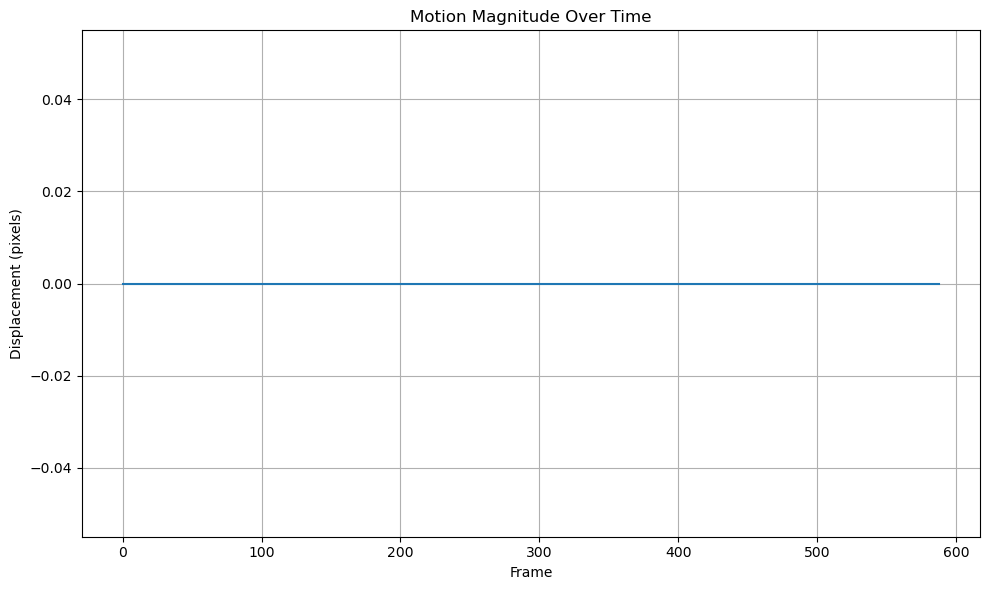

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
import os
import time
from optimized_klt_log_demons import OptimizedKLTLogDemonsCorrection, fast_motion_correct

def main():
    """
    Example of how to use the optimized KLT-Log-Demons motion correction.
    """
    # Path to your data file - update this with your file path
    input_file_path = r"F:\Recovered\Research\BoninLab\PainModelingProject\calcium_imaging_data\CAAR Testing\CAAR part2 data\disinhibition\New folder (2)\Disinhib1_7.23.20_contra3_25um_cor.tif"
    
    # Set output directory
    output_dir = r"F:\Recovered\Research\BoninLab\PainModelingProject\calcium_imaging_data\CAAR Testing\Logdemonsoutput\LDoutput_1"
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Loading data from: {input_file_path}")
    try:
        # Load data
        video_data = imread(input_file_path)
        
        # Alternative loading options
        # For numpy arrays
        # video_data = np.load(input_file_path)
        
        # For HDF5 files
        # import h5py
        # with h5py.File(input_file_path, 'r') as f:
        #     video_data = f['dataset_name'][:]
    except Exception as e:
        print(f"Error loading data: {e}")
        return
    
    # Check if data loaded properly
    if video_data is None or video_data.size == 0:
        print("Failed to load data or data is empty")
        return
    
    print(f"Data loaded successfully: shape={video_data.shape}, dtype={video_data.dtype}")
    
    # Ensure data is 3D [frames, height, width]
    if len(video_data.shape) > 3:
        print(f"Data has {len(video_data.shape)} dimensions. Using first channel/volume.")
        # For 4D data [time, z, y, x] or [time, channel, y, x]
        if video_data.shape[1] <= 10:  # Likely channels or z-slices
            # Taking first channel/z-slice
            video_data = video_data[:, 0, :, :]
        else:
            print("Cannot determine how to reshape data. Please reshape data to [frames, height, width].")
            return
    
    # Convert to float32 if needed
    if video_data.dtype != np.float32:
        # Normalize to 0-1 range if data is integer type
        if np.issubdtype(video_data.dtype, np.integer):
            video_data = video_data.astype(np.float32) / np.iinfo(video_data.dtype).max
        else:
            video_data = video_data.astype(np.float32)
        print(f"Converted data to float32 with range [{video_data.min()}, {video_data.max()}]")
    
    # Set acceleration parameters
    template_idx = 0     # Use first frame as template
    downsample_factor = 2  # Process at half resolution (4x faster)
    demons_every = 5     # Only apply demons every 5th frame (5x faster)
    max_iters = 5        # Reduce iterations (2x faster)
    n_processes = 8      # Increase number of processes
    
    print("\nSPEED OPTIMIZATION SETTINGS:")
    print(f"- Downsampling factor: {downsample_factor}x (processing at {100/downsample_factor:.1f}% resolution)")
    print(f"- Log-demons algorithm applied every {demons_every} frames")
    print(f"- Using {max_iters} iterations per demons step (reduced)")
    print(f"- Parallel processing with {n_processes} processes")
    
    # Option 1: Use the simplified function
    print("\nStarting motion correction...")
    start_time = time.time()
    
    corrected_frames, velocity_fields, rigid_transforms = fast_motion_correct(
        video_data,
        template_idx=template_idx,
        downsample_factor=downsample_factor,
        demons_every=demons_every,
        max_iters=max_iters,
        n_processes=n_processes,
        output_dir=output_dir,
        save_results=True
    )
    
    elapsed_time = time.time() - start_time
    print(f"\nMotion correction completed in {elapsed_time:.2f} seconds")
    
    # Save corrected video as TIFF
    print("Saving corrected video as TIFF...")
    corrected_file_path = os.path.join(output_dir, 'corrected_video.tif')
    imwrite(corrected_file_path, 
            corrected_frames.astype(np.float32),
            photometric='minisblack')
    
    # Option 2: For more control, use the class directly
    """
    # Uncomment to use the class directly with more parameters
    mc = OptimizedKLTLogDemonsCorrection(
        max_iters=max_iters,
        sigma_fluid=2.0,
        sigma_diffusion=2.0,
        step_size=1.0,
        use_klt=True,
        batch_size=100,
        n_processes=n_processes,
        downsample_factor=downsample_factor,
        demons_every=demons_every,
        verbose=True
    )
    
    corrected_frames, velocity_fields, rigid_transforms = mc.correct_batch(
        video_data, template_idx=template_idx
    )
    """
    
    # Visualize a few key metrics
    plt.figure(figsize=(10, 6))
    
    # Plot motion magnitude over time
    motion_magnitude = np.sqrt(rigid_transforms[:, 0]**2 + rigid_transforms[:, 1]**2)
    plt.plot(motion_magnitude)
    plt.title('Motion Magnitude Over Time')
    plt.xlabel('Frame')
    plt.ylabel('Displacement (pixels)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'motion_magnitude.png'))
    
    print(f"\nResults saved to {output_dir}")
    print("Done!")

if __name__ == "__main__":
    main()